# Changes in Shot Frequency Between Regular Season and Playoffs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import myFunctions as mf
import importlib
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from dateutil import parser
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from dateutil import parser
import datetime

In [2]:
importlib.reload(mf)

<module 'myFunctions' from '/home/jovyan/Pstat134/Final Project/BasketballPlayoffs/myFunctions.py'>

In [3]:
plyrs = pickle.load(open( "allplayers.p", "rb" ))
plyrsreg = pickle.load(open("allplayersregular.p","rb"))
allshotspoff = pickle.load(open( "allshotspoff2017.p", "rb" ))
allshotsreg = pickle.load(open("allshotsreg2017.p","rb"))
PIDS = [i for i in plyrs.keys()]

After importing our pickled datafiles, we can now aggregate our data. Here, our goal is to have information on the proportion of shots a player is making with respect to their team on a given game. The average of these values will be our metric to determine players shot frequency during one of the seasons.

In [4]:
aggregation = {'SHOT_ATTEMPTED_FLAG': {'TOTAL_SHOTS': 'sum'}}

playOffTeams = allshotspoff.TEAM_NAME.unique()
playOffNames = allshotspoff.PLAYER_NAME.unique()
teamTotalReg = allshotsreg[allshotsreg.TEAM_NAME.isin(playOffTeams)].groupby(['GAME_ID','TEAM_NAME']).agg(aggregation)
teamTotalPoff = allshotspoff.groupby(['GAME_ID','TEAM_NAME']).agg(aggregation)
teamTotalReg.columns = teamTotalReg.columns.droplevel(0)

teamTotalPoff.columns = teamTotalPoff.columns.droplevel(0)

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [5]:
plyrsTotalReg = allshotsreg[np.logical_and(allshotsreg.TEAM_NAME.isin(playOffTeams),allshotsreg.PLAYER_NAME.isin(playOffNames))].groupby(['GAME_ID','TEAM_NAME','PLAYER_NAME']).agg(aggregation)
plyrsTotalPoff = allshotspoff.groupby(['GAME_ID','TEAM_NAME','PLAYER_NAME']).agg(aggregation)
plyrsTotalReg


# Getting percentile shots
plyrsTotalReg['TEAM_TOTAL_SHOTS'] = teamTotalReg.TOTAL_SHOTS
plyrsTotalReg['PCT_SHOTS'] = plyrsTotalReg.SHOT_ATTEMPTED_FLAG.TOTAL_SHOTS.values / plyrsTotalReg.TEAM_TOTAL_SHOTS.values
plyrsTotalPoff['TEAM_TOTAL_SHOTS'] = teamTotalPoff.TOTAL_SHOTS
plyrsTotalPoff['PCT_SHOTS'] = plyrsTotalPoff.SHOT_ATTEMPTED_FLAG.TOTAL_SHOTS.values / plyrsTotalPoff.TEAM_TOTAL_SHOTS.values


Now we will take the difference between this value for the regular season and the playoff season

In [6]:
## Getting percentile difference
meanPctReg = plyrsTotalReg.groupby('PLAYER_NAME').mean()
meanPctPoff = plyrsTotalPoff.groupby('PLAYER_NAME').mean()
sumTable = meanPctReg
sumTable["SHOTAVG"] = (allshotsreg[allshotsreg.PLAYER_NAME.isin(playOffNames)].groupby(["PLAYER_NAME"])["SHOT_MADE_FLAG"].sum()/allshotsreg[allshotsreg.PLAYER_NAME.isin(playOffNames)].groupby(["PLAYER_NAME"]).size()).values
sumTable['PCT_SHOTS_POFF'] = meanPctPoff.PCT_SHOTS.values
sumTable['PCT_DIFF'] = (meanPctPoff.PCT_SHOTS.values - meanPctReg.PCT_SHOTS.values)

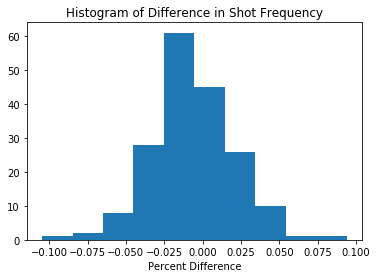

In [7]:
bins = plt.hist(sumTable.PCT_DIFF, bins = 10)
plt.xlabel("Percent Difference")
plt.title("Histogram of Difference in Shot Frequency")
plt.show()

We see that the percent difference is approximately normal. Maybe the players on any given extreme share some kind of relationship?

In [8]:
def inBin(value, bins):
    if(value > bins[len(bins)-1]):
        return(bins[len(bins)-1])
    for i in range(len(bins)):
        if(value >= bins[i] and value <= bins[i+1]):
            return i

Here we can use the player information downloaded from the endpoint to examine possible trends and clusters that may correspond to changes in a players shot proportion

In [9]:
plyrInfo = pickle.load(open('plyrinfo2017.p','rb'))

In [10]:
plyrInfoPoff = plyrInfo[plyrInfo.DISPLAY_FIRST_LAST.isin(playOffNames)]
plyrInfoPoff = plyrInfoPoff.sort_values("DISPLAY_FIRST_LAST")
plyrInfoPoff["PCT_DIFF"] = sumTable.PCT_DIFF.values

In [11]:
def ft2inches(value):
    if(value == ''):
        return np.NaN
    valuelist = value.split("-")
    return int(valuelist[0])*12+int(valuelist[1])
def yr2age(value):
    now = datetime.datetime.now()
    return(now.year - parser.parse(value).year)

We convert the players height in feet remainder inches to inches and fill in any missing data with values found online

In [12]:
X = pd.DataFrame(plyrInfoPoff[["HEIGHT","WEIGHT"]])
X["AGE"] = [yr2age(i) for i in plyrInfoPoff.BIRTHDATE]

Y = X.copy()
Y["PLAYER_NAME"]= plyrInfoPoff.DISPLAY_FIRST_LAST
for i in range(len(Y.WEIGHT)):
    if Y.WEIGHT.iloc[i] == '':
        print("Weight Missing: ",Y.PLAYER_NAME.iloc[i])
        print(i)
    if Y.AGE.iloc[i] == '':
        print("AGE MISSING: ", Y.PLAYER_NAME.iloc[i],i)
X.WEIGHT.iloc[174] = 220
X.HEIGHT.iloc[174] = "6-6"
X.HEIGHT = [ft2inches(i) for i in X.HEIGHT]
X.WEIGHT = [int(i) for i in X.WEIGHT]

Weight Missing:  Tyreke Evans
174


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Here, we also take players shot averages in order to see if better and more experienced players are getting more playtime during the NBA finals.

In [13]:
X["SHOTAVG"] = sumTable.SHOTAVG.values
X["PCT_SHOTS_REG"] = sumTable.PCT_SHOTS.values
X["PCT_SHOTS_POFF"] = sumTable.PCT_SHOTS_POFF.values
X["PCT_SHOTS_DIFF"] = sumTable.PCT_DIFF.values

In [14]:
sumTable["BIN"] = [inBin(value = i,bins = bins[1]) for i in sumTable.PCT_DIFF]
print(sumTable[["BIN","SHOTAVG","PCT_SHOTS","PCT_SHOTS_POFF"]].groupby("BIN").mean())

      SHOTAVG PCT_SHOTS PCT_SHOTS_POFF
                                      
BIN                                   
0    0.530612  0.119403       0.014856
1    0.534232  0.117530       0.048756
2    0.443523  0.114196       0.058241
3    0.472574  0.096303       0.063083
4    0.472653  0.082209       0.068060
5    0.475717  0.110436       0.112695
6    0.453090  0.116462       0.141237
7    0.468233  0.137195       0.180090
8    0.549206  0.133893       0.188377
9    0.462670  0.173585       0.267405


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


We can see that the players who shot more than average shot even more during the playoffs and vice versa, despite what we would usually expect (regressing to the mean). Interestingly, the players who shot less have a higher than average shot made percentage. This may be because they only take shots theyre sure that they can make, or they only have the opportunity to shoot shots that are likely to be successful.

This can offer a lot of insight on the roles of traditional non-shooters, and how those roles change during the more intense games in the season.

### Clustering and Linear Regression

Now we can try to see if any predictors can accurately predict this change in shot difference, or if it is truly a normally distributed phenomenon.

In [15]:
model = LinearRegression()
xvalues = X[['AGE',"PCT_SHOTS_REG","SHOTAVG"]].values
yvalues = plyrInfoPoff.PCT_DIFF.values.reshape(-1,1)

model.fit(xvalues, yvalues)
print(model.score(xvalues, yvalues))

0.0428029802795592


This low $R^2$ value indicates that there is little correlation between these factors and the change in shot frequency.

In [16]:

model = LinearRegression()
xvalues = X[['AGE',"SHOTAVG"]].values
yvalues = plyrInfoPoff.PCT_DIFF.values.reshape(-1,1)

model.fit(xvalues, yvalues)
print(model.score(xvalues, yvalues))

0.009260162225651625


The significantly lower value for $R^2$ after removing the shot percentile during the regular season indicates that this is the most influential predictor.

Now lets try to use clustering to see if there are any relationships between a players age and shot average and their change in percentile.

In [17]:
from sklearn.preprocessing import normalize
num = 4
clustering = AgglomerativeClustering(n_clusters = num, linkage = 'complete').fit(normalize(X[["AGE","SHOTAVG"]]))
clustering.labels_

array([0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 0,
       2, 0, 3, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 2,
       1, 2, 0, 2, 0, 3, 0, 0, 2, 2, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 3, 1, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0,
       0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 1,
       0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0,
       2, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       2, 0, 2, 2, 2, 0, 2])

In [18]:
X["CLUSTER"] = clustering.labels_
Y = X.copy()
Y["PLAYER_NAME"] = plyrInfoPoff.DISPLAY_FIRST_LAST
Y["CLUSTER"] = clustering.labels_
print(Y)

     HEIGHT  WEIGHT  AGE   SHOTAVG  PCT_SHOTS_REG  PCT_SHOTS_POFF  \
171      81     220   24  0.449331       0.159684        0.152077   
344      78     225   26  0.423256       0.044294        0.011845   
216      82     245   33  0.535270       0.119526        0.147071   
10       81     220   29  0.433390       0.081935        0.076121   
314      80     215   27  0.487273       0.047348        0.039284   
243      81     240   32  0.503185       0.043042        0.024725   
131      83     279   26  0.533270       0.157957        0.148699   
222      78     215   35  0.500000       0.051833        0.090117   
34       82     260   33  0.470852       0.050834        0.021541   
402      76     200   27  0.405594       0.093577        0.074103   
424      82     230   23  0.562500       0.151995        0.112910   
182      82     250   30  0.461596       0.213848        0.211450   
299      87     290   31  0.615385       0.062808        0.063472   
53       80     216   30  0.496670

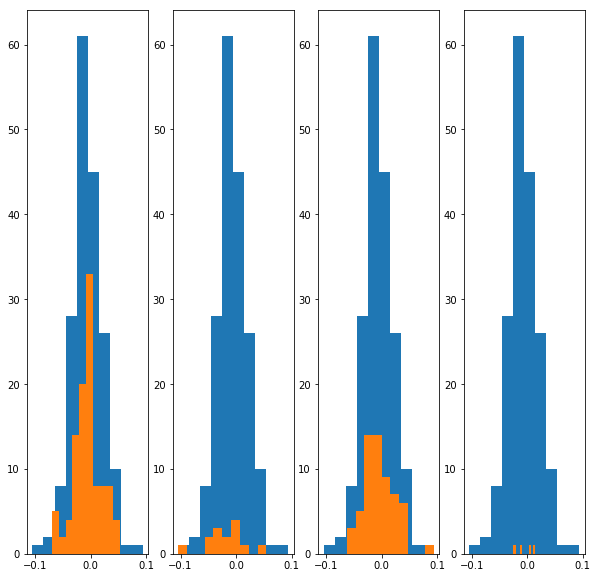

In [19]:
fig,ax = plt.subplots(ncols = num)
fig.set_figheight(10)
fig.set_figwidth(10)
for i in range(num):
    ax[i].hist(X.PCT_SHOTS_DIFF.values, bins = 10)
    ax[i].hist(X[X.CLUSTER == i].PCT_SHOTS_DIFF.values,bins = 10)

We notice that cluster 1 has an average difference in perfentile shots that is below zero, while the others are not quite as conclusive or clear.

In [20]:
X.groupby("CLUSTER")[["AGE","HEIGHT","SHOTAVG","PCT_SHOTS_REG","PCT_SHOTS_POFF"]].mean()

,AGE,HEIGHT,SHOTAVG,PCT_SHOTS_REG,PCT_SHOTS_POFF
CLUSTER,,,,,
0,26.792453,79.198113,0.472563,0.105012,0.098921
1,25.000000,82.571429,0.594315,0.104430,0.087149
2,31.474576,77.677966,0.425502,0.098995,0.094691
3,23.000000,83.000000,0.644048,0.055574,0.050974


We Can see that this group is the average age and has a high shot average, so it is surpising that they collectively shoot significantly less during the playoffs. We can see that they are taller than average. Maybe their position has some relationship with this effect.

In [21]:
Y["POSITION"] = plyrInfoPoff["POSITION"]
print(Y[X.CLUSTER == 1])

     HEIGHT  WEIGHT  AGE   SHOTAVG  PCT_SHOTS_REG  PCT_SHOTS_POFF  \
424      82     230   23  0.562500       0.151995        0.112910   
77       82     240   25  0.647541       0.131028        0.087725   
412      83     240   23  0.590000       0.112815        0.087040   
459      82     245   32  0.694444       0.029120        0.010753   
15       83     242   25  0.578188       0.195802        0.198416   
501      85     240   22  0.559367       0.103346        0.060099   
45       81     233   27  0.602649       0.036844        0.055061   
187      80     240   25  0.614865       0.146457        0.148039   
351      83     220   25  0.586957       0.040620        0.046781   
422      81     230   25  0.549206       0.133893        0.188377   
170      85     245   27  0.668539       0.104672        0.076283   
270      83     235   23  0.530612       0.119403        0.014856   
2        84     265   26  0.594561       0.111795        0.097602   
277      82     225   22  0.540984

#### Analysis

We see that most of the players in this cluster that have a negative change in percentile shot difference are mostly Forwards. While the data we have is not as accurate, from looking at these players positions online, they are usually referred to as power forwards. This players are versatile because they can shoot from within the key and take farther jump shots. It is very interesting that they take fewer shots during the playoffs when their role is so pivotal, but it would take further analysis to determine why this is the trend.

# Conclusion

As a result of the querying we are unable to make any conclusive claims about any positive trends in who is taking more shots in the playoff season than the regular season. All of the analysis we have done thus far points to the conclusion that there is no underlying factor that results in this effect.

Overall, the only consistent underlying trend is that there is a subset of players who, despite having an above average shot average, tend to shoot less frequently during the playoffs than they do during the regular season. These players are generally power forwards, and with a better dataset with more descriptive labels we could more easily scope in on this subset and come to a more concrete conclusion, however the trend is very clear, especially when looking at that last cluster and ignoring players who were centers rather than power forwards.